## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [83]:
## helpful packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [10]:
debar = pd.read_csv("debar.csv")
debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [13]:
# Number of rows is 114
debar.shape[0]

# Unique name is 98
debar["Name"].nunique()

# There are multiple rows for some employers

114

98

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [16]:
is_repeated = debar["Name"].value_counts()>1
is_repeated_names = is_repeated[is_repeated.values==True].index
is_repeated_names

debar["is_repeated"] = np.where(debar["Name"].isin(is_repeated_names), True, False)
debar[debar["is_repeated"]]

mult_debar = debar[debar["is_repeated"]].copy()
mult_debar.head()
mult_debar.shape

Index(['Maple Ridge Custom Services, LLC', 'Loewen Harvesting LLC',
       'Old Tree Farms/Verpaalen Custom Service', 'Dove Creek Farms',
       'Cisco Produce Inc.', 'F&W Farms', 'Mark Duncan', 'SRT Farms',
       'Sharon Mathis', 'Rollo Farm Labor Contractor', 'Turner Farms',
       'Caddo Creek Ranch, dba Paradise Ranch', 'Autumn Hill Orchard',
       'Annabella Land & Cattle', 'Xavier Horne', 'Macky and Brad Farms'],
      dtype='object', name='Name')

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
15,SRT Farms,"Morton, TX",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
16,Mark Duncan,"Roosevelt, UT",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
17,"Maple Ridge Custom Services, LLC","Altheimer, AK",Failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,True
18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,True


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


(32, 7)

Interpretation: Entreprises that appear repeatedly might have different violations (Autumn Hill Orchard) or have the same violation at different times (Turner Farms). 

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [20]:

# correct those that spelled the states differently
mult_debar['City, State'] = mult_debar['City, State'].str.replace("Annabella, Utah", "Annabella, UT")
mult_debar['City, State'] = mult_debar['City, State'].str.replace("Caddo, Texas", "Caddo, TX")
mult_debar['City, State'] = mult_debar['City, State'].str.replace("Altheimer, AK", "Altheimer, AR")
mult_debar['City, State'] = mult_debar['City, State'].str.replace("Brownsville, TX", "Brownfield, TX")

# assign different numbers to the duplicates
mult_debar["violation_count"] = mult_debar.groupby(["Name", "City, State"])["Start date"].rank(method = "first")

# pivot to a wide df
mult_debar_wide = mult_debar.pivot(
    index = ["Name","City, State"],
    columns = "violation_count",
    values = "Start date"
).reset_index()


mult_debar_wide = mult_debar_wide.rename({1.0:"start_date_viol1", 2.0:"start_date_viol2"}, axis=1)
mult_debar_wide
mult_debar_wide.head()
mult_debar_wide.shape

violation_count,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018
5,F&W Farms,"Ingalls, KS",12/10/2014,12/10/2014
6,Loewen Harvesting LLC,"Brownfield, TX",8/20/2014,8/20/2014
7,Macky and Brad Farms,"Plains, TX",2/13/2015,2/13/2015
8,"Maple Ridge Custom Services, LLC","Altheimer, AR",11/16/2014,11/16/2014
9,Mark Duncan,"Roosevelt, UT",11/16/2014,11/16/2014


violation_count,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018


(16, 4)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [24]:
# create is_dup
mult_debar_wide['is_dup'] = (mult_debar_wide.start_date_viol1 == mult_debar_wide.start_date_viol2)

# extract the duplicates
duplicates = mult_debar_wide[mult_debar_wide['is_dup'] == True].Name

# create an indicator for filtering out duplicate employers
is_duplicate = debar['Name'].isin(duplicates)

# use the same method as above to assign numbers to duplicate rows
debar["violation_count"] = debar.groupby(["Name"])["Start date"].rank(method = "first")

# for duplicates, only keep first row
debar_dup = debar[is_duplicate & (debar['violation_count'] == 1.0)]

# for non-duplicates, keep all rows
debar_non_dup = debar[~is_duplicate]

# Concat
debar_clean = pd.concat([debar_dup, debar_non_dup], axis=0).drop(columns=['is_repeated'], errors='ignore')

debar_clean.shape # 101 rows
debar_clean['Name'].nunique() # 98 unique names

(101, 7)

98

# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset2_inputdata`

In [34]:
# your code here to load the data 
jobs = pd.read_csv("jobs.csv")
jobs.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4


##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [37]:
merged = pd.merge(jobs, debar_clean, how = "inner", left_on = "EMPLOYER_NAME", right_on = "Name")
# There is one exact match
merged

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,Name,"City, State",Violation,Duration,Start date,End date,violation_count
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,Rafael Barajas,NaN,...,NaN,https://seasonaljobs.dol.gov/,7,Rafael Barajas,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,1.0


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [41]:
## insert your code to turn into uppercase here
jobs_uppercase = [name.upper() for name in jobs['EMPLOYER_NAME']]

debar_clean_uppercase = [name.upper() for name in debar_clean['Name']]

In [43]:
## insert your code for the random sample
random.sample(jobs_uppercase, 15)
random.sample(debar_clean_uppercase, 15)

['TMG CATTLE',
 'CHRISTOPHER KLUMPP ',
 'J AND J PRODUCE INC.',
 'RICHARD GRAMLOW',
 'GEORGE STOLTZ (STOLTZ LAND & CATTLE CO.)',
 'G. CISNEROS HARVESTING, INC.',
 'COIGNARD BROTHERS, LLC',
 'DESHOTELS CRAWFISH FARMS LLC',
 'LIONEL MOUNIER JR FARM',
 'K & M BLUEBERRY FARM AND NURSERY',
 'STEVEN L. HARNAGE',
 'STEPHENS FARM PARTNERSHIP',
 'PALISADE PEACH SHACK, INC.',
 'HONEY ROCK, LLC',
 "THE NORTH CAROLINA GROWER'S ASSOCIATION, INC."]

['SAXTONS RIVER ORCHARDS, INC.',
 'ALTENDORF TRANSPORT INC.',
 'GLENDA HARROD FARMS',
 'C HANGING L RANCH LLP',
 'CHRIS ROBINSON',
 'YESENIA PEREZ',
 'PEACH CREST FARM, LLC',
 'CIRA CORTEZ LOPEZ',
 'RUBEN RUIZ (DESOTO HARVESTING)',
 'FIRST AMERICAN HOLDING',
 'DONNA LUCIO',
 'F&W FARMS',
 'CADDO CREEK RANCH, DBA PARADISE RANCH',
 'LOV RANCH CO, LLLP DBA LOV RANCH',
 'LOEWEN HARVESTING LLC']

In [96]:
## insert your code for assigning the uppercase names back to the data
jobs['EMPLOYER_NAME'] = jobs_uppercase
debar_clean['Name'] = debar_clean_uppercase

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [48]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [50]:
## insert your code here with the regex pattern for part A
## insert your code here with the regex pattern for part A
regex = r"(\s+)(INC|LLC|CO)\."
# alternatively,
# regex = r"\b(INC|LLC|CO)\."

## insert your code to use re.sub to apply the pattern to the test cases for part B
re.sub(regex, r"\1\2", pos_example_1)
re.sub(regex, r"\1\2", pos_example_2)
re.sub(regex, r"\1\2", neg_example)

## insert your code to use re.sub to apply the pattern to the test cases for part B

'CISCO PRODUCE INC'

'AVOYELLES HONEY CO, LLC'

'E.V. RANCH LLP'

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [53]:
## your code here to clean the columns

jobs['name_clean'] = [re.sub(regex, r'\1\2', name) for name in jobs['EMPLOYER_NAME']]

debar_clean['name_clean'] = [re.sub(regex, r'\1\2', name) for name in debar_clean['Name']]

In [55]:
## your code here to print the head
jobs_changed = jobs[jobs['EMPLOYER_NAME'] != jobs['name_clean']]
jobs_changed[['EMPLOYER_NAME', 'name_clean']].head()

debar_clean_changed = debar_clean[debar_clean['Name'] != debar_clean['name_clean']]
debar_clean_changed[['Name', 'name_clean']].head()

,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"


,Name,name_clean
3,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","GREAT PLAINS FLUID SERVICE, INC"
5,PROMAX INC.,PROMAX INC
13,REIMER'S INC.,REIMER'S INC
19,CISCO PRODUCE INC.,CISCO PRODUCE INC


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [58]:
#Part A
clean_merged = pd.merge(jobs, debar_clean, how = "inner", left_on = "name_clean", right_on = "name_clean", suffixes=('_jobs', '_debar'))
clean_merged
# The cleaning didn't result in more matches

#Part B
regex_2 = r"(.*)\.(.*)\.(.*)\s(.*)"
debar_clean['name_clean_2'] = [re.sub(regex_2, r'\1\2\3', name) for name in debar_clean['Name']]
# a = re.sub(regex_2, r'\1\2\3', "SLASH E.V. RANCH LLP")

#Part C
clean_merged_2 = pd.merge(jobs, debar_clean, indicator="indicator", how = "left", left_on = "name_clean", right_on = "name_clean_2", suffixes=('_jobs', '_debar'))
clean_merged_2[clean_merged_2["indicator"]=="both"]


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,name_clean,Name,"City, State",Violation,Duration,Start date,End date,violation_count
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,https://seasonaljobs.dol.gov/,7,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,1.0


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,Name,"City, State",Violation,Duration,Start date,End date,violation_count,name_clean_debar,name_clean_2,indicator
791,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,1.0,RAFAEL BARAJAS,RAFAEL BARAJAS,both
1115,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,1.0,SLASH E.V. RANCH LLP,SLASH EV RANCH,both


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [101]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## A: your code here to define the pattern
regex_pattern = r"(.+?)\s\(COMPANY\).*AND\s(.+?)\s\(INDIVIDUAL\)"

## B: your code here to apply it to the pos_example
pos_match = re.findall(regex_pattern, pos_example)

## your code here to apply it to the negative example
neg_match = re.findall(regex_pattern, neg_example)

pos_match, neg_match

([('COUNTY FAIR FARM', 'ANDREW WILLIAMSON')], [])

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [103]:
# your code here
# iterate over the name_clean column in debar and use regex to create two new columns in debar_clean
def update_company_individual_columns(df):
    co_names = []
    ind_names = []
    
    for name_clean in df['name_clean']:
        match = re.search(regex_pattern, name_clean)
        if match:
            co_name, ind_name = match.groups()
        else:
            co_name = ind_name = name_clean 
        co_names.append(co_name)
        ind_names.append(ind_name)
    
    df['co_name'] = co_names
    df['ind_name'] = ind_names
    return df

debar_clean_updated = update_company_individual_columns(debar_clean)
debar_clean_updated.head()

,Name,"City, State",Violation,Duration,Start date,End date,violation_count,name_clean,name_clean_2,co_name,ind_name,State
6,ANNABELLA LAND & CATTLE,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,1.0,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,UT
7,AUTUMN HILL ORCHARD,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,1.0,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,MA
8,"CADDO CREEK RANCH, DBA PARADISE RANCH","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,1.0,"CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH",TX
11,LOEWEN HARVESTING LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,1.0,LOEWEN HARVESTING LLC,LOEWEN HARVESTING LLC,LOEWEN HARVESTING LLC,LOEWEN HARVESTING LLC,TX
12,ROLLO FARM LABOR CONTRACTOR,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,1.0,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR CONTRACTOR,ROLLO FARM LABOR CONTRACTOR,FL


   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [77]:
# your code here
filtered_rows = debar_clean_updated[
    (debar_clean_updated['name_clean'].str.contains("COUNTY FAIR FARM")) |
    (debar_clean_updated['name_clean'].str.contains("CISCO PRODUCE"))
]

filtered_rows[['name_clean', 'co_name', 'ind_name', 'Violation']]

,name_clean,co_name,ind_name,Violation
19,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Failure to respond to audit (no response)
56,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Impeding the Audit Process – Non- Response
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in clas1s so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='WORKSITE_STATE'>

Text(0.5, 1.0, 'Number of Job Cases by State in Guestworker Jobs Dataset')

Text(0.5, 0, 'State')

Text(0, 0.5, 'Number of Job Cases')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 [Text(0, 0, 'LA'),
  Text(1, 0, 'TX'),
  Text(2, 0, 'FL'),
  Text(3, 0, 'CA'),
  Text(4, 0, 'ND'),
  Text(5, 0, 'ID'),
  Text(6, 0, 'MS'),
  Text(7, 0, 'CO'),
  Text(8, 0, 'AR'),
  Text(9, 0, 'MT'),
  Text(10, 0, 'UT'),
  Text(11, 0, 'GA'),
  Text(12, 0, 'SD'),
  Text(13, 0, 'AZ'),
  Text(14, 0, 'WY'),
  Text(15, 0, 'KS'),
  Text(16, 0, 'NE'),
  Text(17, 0, 'KY'),
  Text(18, 0, 'WA'),
  Text(19, 0, 'MN'),
  Text(20, 0, 'OK'),
  Text(21, 0, 'AL'),
  Text(22, 0, 'NC'),
  Text(23, 0, 'NV'),
  Text(24, 0, 'NY'),
  Text(25, 0, 'SC'),
  Text(26, 0, 'OR'),
  Text(27, 0, 'TN'),
  Text(28, 0, 'IA'),
  Text(29, 0, 'OH'),
  Text(30, 0, 'PA'),
  Text(31, 0, 'MO'),
  Text(32, 0, 'MI'),
  Text(33, 0, 'IL'),
  Text(34, 0, 'IN'),
  Text(35, 0, 'NM'),
  Text(36, 0, 'VA'),
  Text(37, 

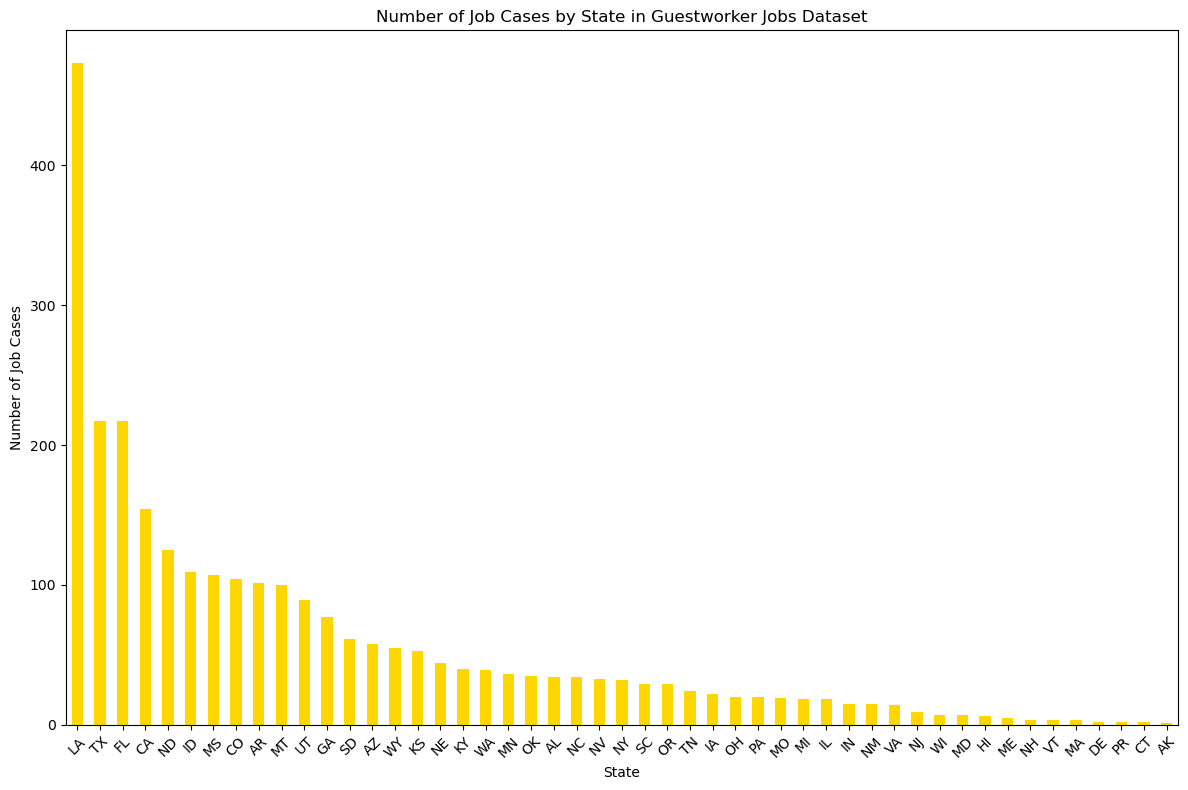

In [111]:
# Group by state and count the number of job cases per state to visualize between-state variation
state_job_counts = jobs['WORKSITE_STATE'].value_counts()

# Plot the job counts by state
plt.figure(figsize=(12, 8))
state_job_counts.plot(kind='bar',color='gold')
plt.title('Number of Job Cases by State in Guestworker Jobs Dataset')
plt.xlabel('State')
plt.ylabel('Number of Job Cases')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()